In [2]:
from utils import *
h2 = H2Toolkit()
h2.check_torch_gpu()

Torch version: 2.0.0+cu117
Torch build with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080


In [3]:
h2.read_data(n_subsample=10000)
h2.process_data(restype='SA')

CH4: (10000, 17) | CO2: (10000, 17) | N2: (10000, 17) | NOCG: (10000, 17)
All: (10000, 17)
Full dataset shape: (10000, 17)
Truncated dataset shape: (10000, 17)
Clean (no outliers) dataset shape: (9169, 17)
Dataset: X=(9169, 12) | y=(9169, 3)


In [4]:
h2.train_valid_test_split()
h2.arrays_to_tensors()
h2.make_dataloader()

X: train: (6235, 12) | validation: (1100, 12) | test: (1834, 12)
y: train: (6235, 3)  | validation: (1100, 3)  | test: (1834, 3)


Epoch: 250/250 -- Loss: 0.17851, Validation Loss: 0.10466: 100%|██████████| 250/250 [00:34<00:00,  7.26it/s]


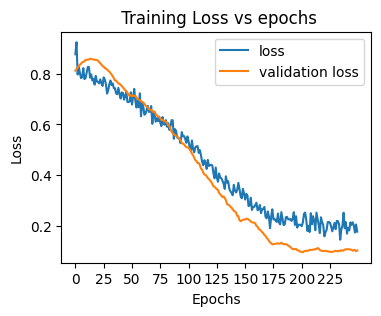

In [8]:
rom  = h2_cushion_rom(h2.inp, h2.out, hidden_sizes=[32,64,128,64,32,16])
opt  = optim.Adam(rom.parameters(), lr=1e-3, weight_decay=1e-5)
loss = L1L2_Loss()
loss.l2_weight = 1

h2.train(rom, loss, opt)
h2.plot_loss()

Train Pred shape: (6235, 3)
Test Pred shape:  (1834, 3)
TRAIN: R2=0.408 | MSE=0.01687 | MAE=0.10164
TEST:  R2=0.406 | MSE=0.01639 | MAE=0.10073
---------------
efft TRAIN: R2=0.514    | TEST: R2=0.503
efft TRAIN: MSE=0.01196 | TEST: MSE=0.01162
efft TRAIN: MAE=0.08622 | TEST: MAE=0.08509
---------------
ymft TRAIN: R2=0.297    | TEST: R2=0.316
ymft TRAIN: MSE=0.02289 | TEST: MSE=0.02160
ymft TRAIN: MAE=0.11582 | TEST: MAE=0.11299
---------------
gwrt TRAIN: R2=0.414    | TEST: R2=0.400
gwrt TRAIN: MSE=0.01576 | TEST: MSE=0.01594
gwrt TRAIN: MAE=0.10289 | TEST: MAE=0.10410


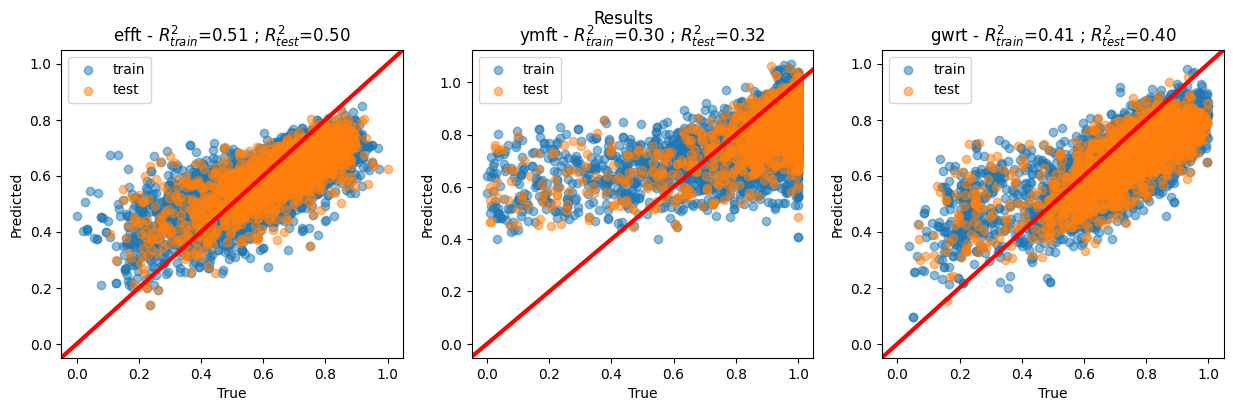


Data is Saved! ..... DONE!


In [9]:
h2.make_predictions(rom)
h2.print_metrics()
h2.plot_results()
h2.save_data(rom)

In [ ]:
#make_dot(rom(X_train_tensor), params=dict(rom.named_parameters()))

***
# END